In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from scipy.stats import f_oneway, kruskal
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, davies_bouldin_score, f1_score, roc_curve, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.utils import resample
from enum import Enum
from kneed import KneeLocator
from collections import defaultdict
from sklearn.svm import SVC
warnings.filterwarnings("ignore")

In [2]:
DATASET_NAME = 'Spotify_Dataset_V4.csv'
DATASET_PATH = os.path.join('datasets', DATASET_NAME)
song_data = pd.read_csv(DATASET_PATH)
song_data.info()
song_data.describe()
spotify_song_data = song_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Rank                              651936 non-null  int64  
 1   Title                             651936 non-null  object 
 2   Artists                           651936 non-null  object 
 3   Date                              651936 non-null  object 
 4   Danceability                      651936 non-null  float64
 5   Energy                            651936 non-null  float64
 6   Loudness                          651936 non-null  float64
 7   Speechiness                       651936 non-null  float64
 8   Acousticness                      651936 non-null  float64
 9   Instrumentalness                  651936 non-null  float64
 10  Valence                           651936 non-null  float64
 11  # of Artist                       651936 non-null  o

In [3]:
spotify_song_data.head()

# artist average points
# unique artists list i.e. Eslabon Armado, Peso Pluma -> split by comma
unique_artists = spotify_song_data['Artist (Ind.)'].unique()
unique_artists = list(unique_artists)

average_points = spotify_song_data.groupby(['id'])['Points (Total)'].mean().reset_index()

average_points.rename(columns={'Points (Total)': 'Average_Points'}, inplace=True)

song_data = pd.merge(spotify_song_data, average_points, on='id')
# drop duplicate id
song_data.drop_duplicates(subset=['id'], inplace=True)

unique_songs = song_data.dropna(subset=song_data.columns.difference(['genres']))

# artists dict to store individual artist's average points
artists_score = defaultdict(float)
for artist in unique_artists:
    artists_score[artist] = spotify_song_data[spotify_song_data['Artist (Ind.)'] == artist]['Points (Ind for each Artist/Nat)'].mean()
# artist average points
for index, row in unique_songs.iterrows():
    if "Tyler, The Creator" in row['Artists']:
        artists = ['Tyler, The Creator'] + row['Artists'].replace('Tyler, The Creator', '').split(', ')
    else:
        artists = row['Artists'].split(', ')
    
    unique_songs.loc[index, 'Artists_Average_Points'] = sum([artists_score[artist] for artist in artists]) / len(artists)
    
# genres
main_genres = ['pop', 'rock', 'hip hop', 'rap', 'r&b', 'country', 'jazz', 'classical', 'electronic', 'dance', 'latin', 'reggae', 'blues', 'soul', 'funk', 'metal', 'punk', 'folk', 'world', 'indie', 'corrido']

def categorize_genre(sub_genres):
    sub_genres_list = str(sub_genres).lower().split(',')
    for main_genre in main_genres:
        if any(main_genre in sub_genre for sub_genre in sub_genres_list):
            return main_genre
    return 'other'

unique_songs['General_Genre'] = unique_songs['genres'].apply(categorize_genre)

columns_to_drop = ['# of Artist', 'Artist (Ind.)', '# of Nationality', 'Nationality', 
                   'Points (Ind for each Artist/Nat)', 'Points (Total)', 'Song URL', 'genres', 'Date', 'Rank']

unique_songs = unique_songs.drop(columns=columns_to_drop, errors='ignore')

unique_songs.head(10)

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent,...,key,liveness,mode,tempo,time_signature,duration_ms,Month,Average_Points,Artists_Average_Points,General_Genre
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Latin-America,...,5.0,0.0837,0.0,147.989,3.0,165671.0,5,199.531250,66.506683,corrido
64,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Latin-America,...,9.0,0.1120,0.0,143.978,4.0,231704.0,5,198.909091,75.923013,rap
75,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Latin-America,...,2.0,0.0756,0.0,169.922,4.0,234353.0,5,189.123288,75.853741,reggae
221,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Asia,...,11.0,0.3470,0.0,120.018,4.0,174253.0,5,193.525424,126.928000,pop
280,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Latin-America,...,6.0,0.2700,0.0,83.118,4.0,194563.0,5,199.046512,76.654777,rap
366,Flowers,Miley Cyrus,0.707,0.681,-4325.0,0.067,0.063,0.000,0.646,Anglo-America,...,0.0,0.0322,1.0,117.999,4.0,200455.0,5,197.851852,117.574468,pop
447,Daylight,David Kushner,0.508,0.430,-9475.0,0.034,0.830,0.000,0.324,Anglo-America,...,2.0,0.0930,0.0,130.090,4.0,212954.0,5,194.000000,178.846154,other
493,Kill Bill,SZA,0.644,0.735,-5747.0,0.039,0.052,0.144,0.418,Anglo-America,...,8.0,0.1610,1.0,88.980,4.0,153947.0,5,196.843023,99.472439,pop
665,As It Was,Harry Styles,0.520,0.731,-5338.0,0.056,0.342,0.001,0.662,Europe,...,6.0,0.3110,0.0,173.930,4.0,167303.0,5,195.493333,117.918118,pop
1040,TQG,"KAROL G, Shakira",0.720,0.630,-3547.0,0.277,0.673,0.000,0.607,Latin-America,...,4.0,0.0936,0.0,179.974,4.0,199440.0,5,195.568421,72.950740,pop


In [33]:
for index, row in unique_songs.iterrows():
    columns = row.index[row.isnull()]
    if len(columns) > 0:
        print(index, row) 

## Define is popular or not

In [142]:
top_average_points = unique_songs['Average_Points'].quantile(0.75)

# defind is_popular as 1, 2, 3, 4 quartile
# unique_songs['is_popular'] = pd.qcut(unique_songs['Average_Points'], q=4, labels=False)
unqiue_songs = unique_songs[unique_songs['Average_Points'] >= top_average_points]

# top_popularity = unique_songs['popularity'].quantile(0.75)
# unique_songs['is_popular'] = (unique_songs['popularity'] >= top_popularity).astype(int)
print('Popularity threshold: ', top_average_points)

Popularity threshold:  104.52564102564102


# EDA on the data with respect to is_popular

<Figure size 2000x1000 with 0 Axes>

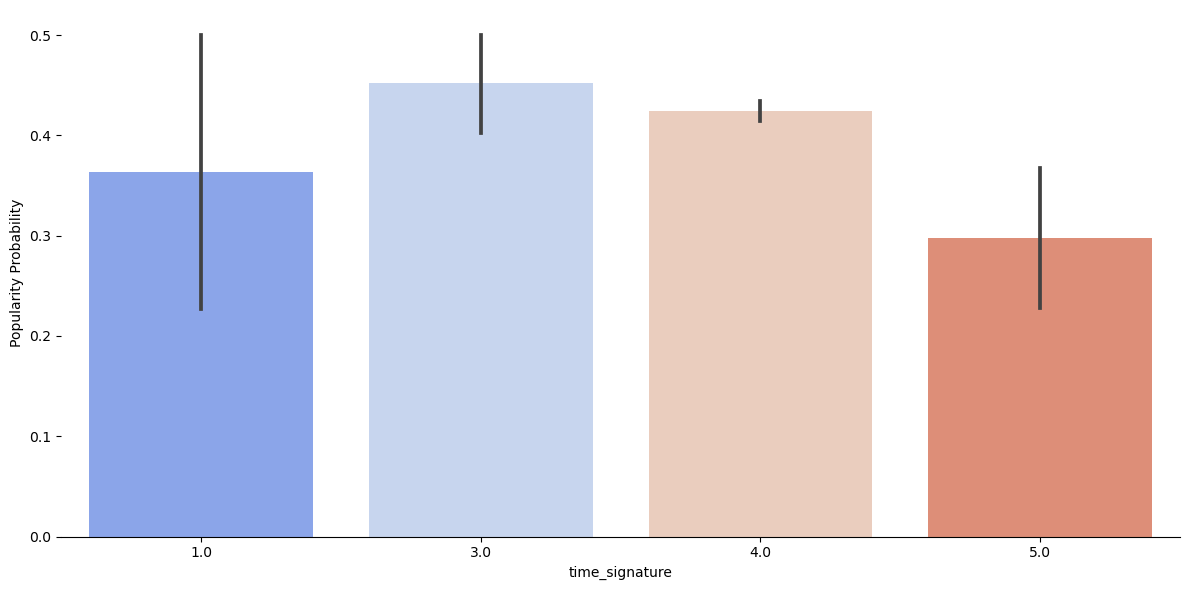

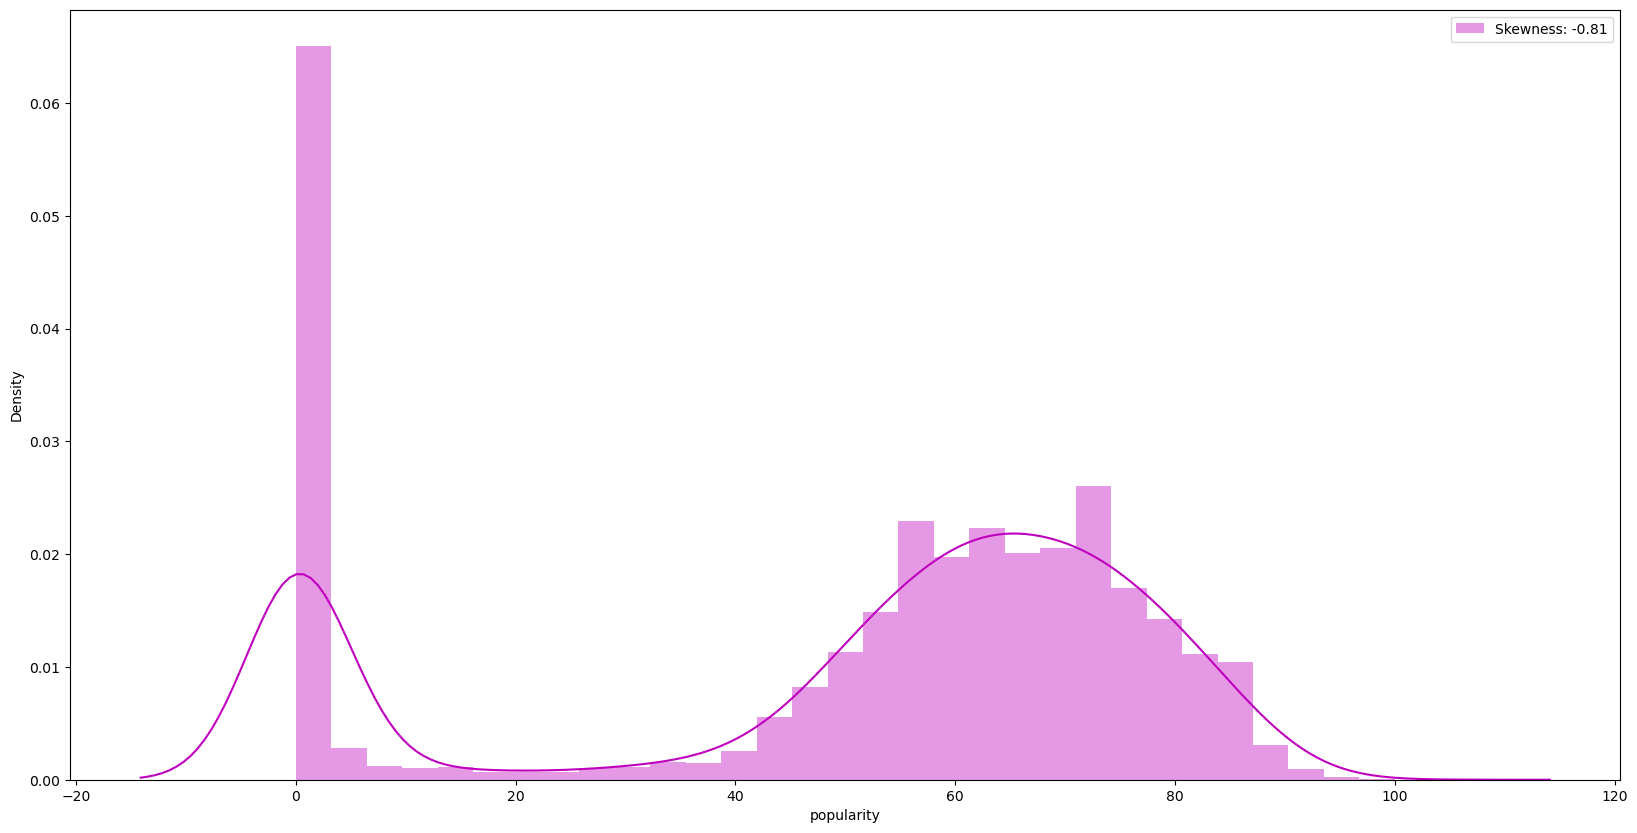

In [35]:
def plot_distribution(df, column, target='popularity'):
    # plot the factorplot
    plt.figure(figsize=(20, 10))
    g = sns.factorplot(x=column, y=target, data=df, kind='bar', size=6, aspect=2, palette='coolwarm')
    g.despine(left=True)
    g = g.set_ylabels('Popularity Probability')
    plt.show()

def plot_feature_distribution(df, column):
    plt.figure(figsize=(20, 10))
    # plot the distribution of the feature
    g = sns.distplot(df[column], color='m', label='Skewness: %.2f'%(df[column].skew()))
    g = g.legend(loc='best')
    plt.show()
    
# plot_distribution(unique_songs, "key", 'is_popular')
# plot_distribution(unique_songs, "mode", 'is_popular')
plot_distribution(unique_songs, "time_signature", 'is_popular')
plot_feature_distribution(unique_songs, 'popularity')

In [139]:
feature_columns =   ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'tempo', 'mode', 'time_signature', 'Artists_Average_Points', 'duration_ms']
target_column = 'is_popular'

Before removing outliers:  (9161, 23)
After removing outliers:  (6108, 23)
Records of is_popular = 1:  1540
Records of is_popular = 0:  1518


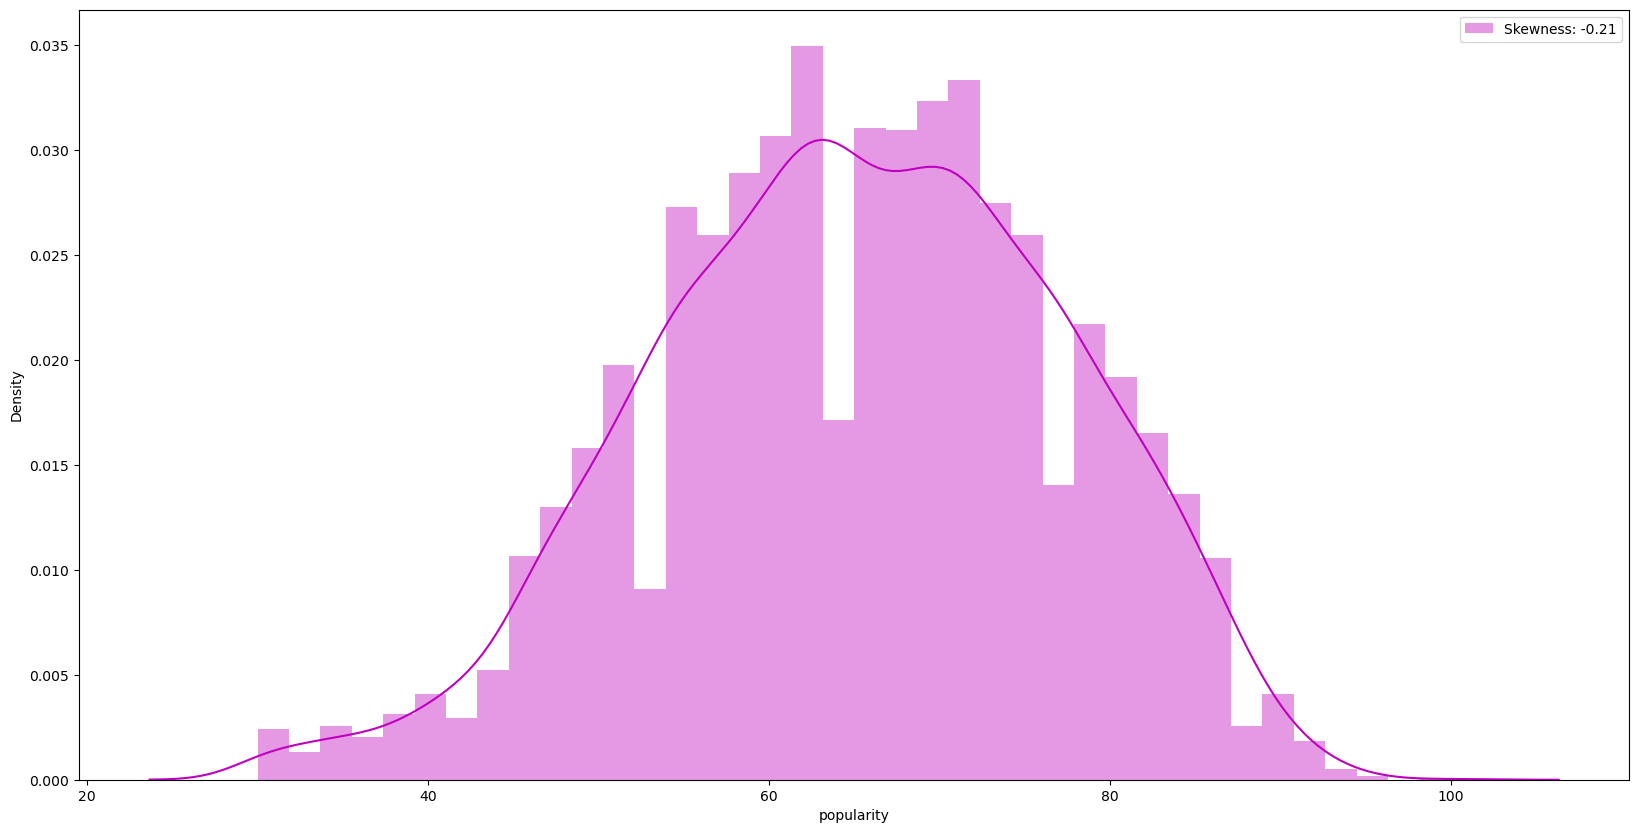

In [140]:
def remove_outliers(data: pd.DataFrame, columns: list, threshold=3, popularity_threshold=30):
    # remove outliers based on the given columns
    for column in columns:
        data = data[np.abs(stats.zscore(data[column])) < threshold]
    
    # remove when popularity is smaller than 40
    data = data[data['popularity'] >= popularity_threshold] 
    return data
    
print('Before removing outliers: ', unique_songs.shape)
processed_data = remove_outliers(unique_songs, feature_columns)
print('After removing outliers: ', processed_data.shape)

print('Records of is_popular = 1: ', len(processed_data[processed_data['is_popular'] == 1]))
print('Records of is_popular = 0: ', len(processed_data[processed_data['is_popular'] == 0]))

# plot the popularity distribution
plt.figure(figsize=(20, 10))
g = sns.distplot(processed_data['popularity'], color='m', label='Skewness: %.2f'%(processed_data['popularity'].skew()))
g = g.legend(loc='best')
plt.show()


In [38]:
## Feature Engineering
# 1. Standardization
# 2. Normalization
# 3. PCA
# 4. Feature Selection
# 5. Feature Extraction
# 6. Feature Construction
# 7. Feature Learning


## Visualize the song features distribution

In [131]:
song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

def plot_distribution(data: pd.DataFrame, columns: list = song_attributes):

    # plot the distribution of each song attribute in subplots
    plt.figure(figsize=(20, 10))
    for i, attribute in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data=data, x=attribute, kde=True)
        plt.title(f'Distribution of {attribute}')
    plt.tight_layout()
    plt.show()
    
def plot_correlation(data: pd.DataFrame):
    # plot the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, cmap='viridis')
    plt.title('Correlation Matrix')
    plt.show()
    

def normalize(data: pd.DataFrame, columns: list = song_attributes):
    # normalize the data
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

def remove_outliers(data: pd.DataFrame, columns: list = song_attributes):
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)
    model.fit(data[columns])
    data['anomaly'] = pd.Series(model.predict(data[columns]))
    data = data[data['anomaly'] == 1]
    data = data.drop(columns=['anomaly'])
    data.reset_index(drop=True, inplace=True)
    return data

def plot_count_for_continent(data: pd.DataFrame):
    continents = data['Continent'].unique()
    print(pd.DataFrame(data['Continent'].value_counts()))
    plt.figure(figsize=(20, 10))
    # for bar plot in one graph
    plt.bar(continents, data['Continent'].value_counts(), color='skyblue')
    plt.xlabel('Continent')
    plt.ylabel('Count')
    plt.title('Count for Continent')
    plt.show()
    
    
# print("Before removing outliers: ", normalized_monthly_unique_songs.shape)
# cleaned_song_data = remove_outliers(normalized_monthly_unique_songs, song_attributes)
# print("After removing outliers: ", cleaned_song_data.shape)
# print(unique_songs.columns)
# plot_distribution(unique_songs, song_attributes)
# plot_count_for_continent(unique_songs)

refined_song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence']

## Reduce dimensionalities by PCA to reduce noise

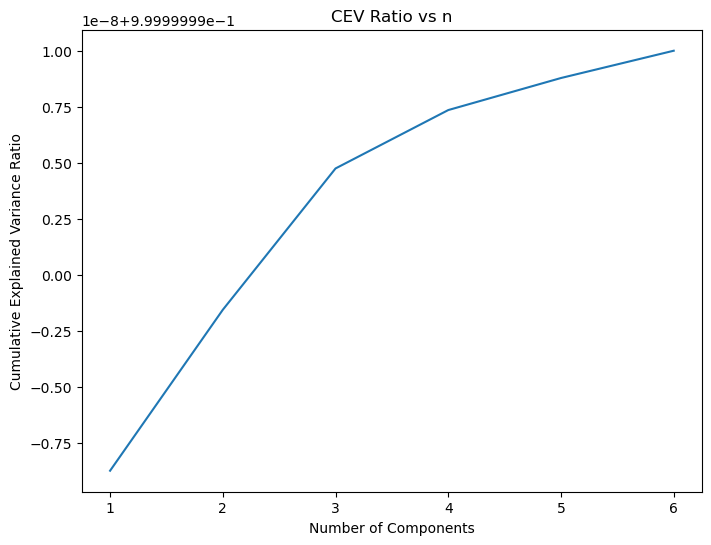

Knee Point: 3
Explained Variance Ratio: 0.9999999947517096


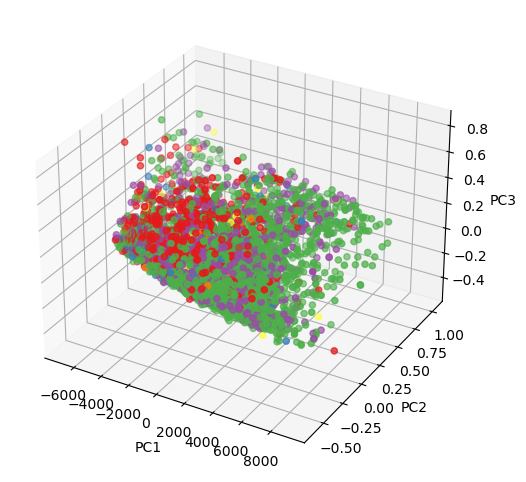

(6108, 26) (9161, 23) Index(['Title', 'Artists', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Valence', 'Continent', 'id',
       'popularity', 'key', 'liveness', 'mode', 'tempo', 'time_signature',
       'duration_ms', 'Month', 'Average_Points', 'Artists_Average_Points',
       'General_Genre', 'is_popular', 'PC1', 'PC2', 'PC3'],
      dtype='object') Index(['Title', 'Artists', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Valence', 'Continent', 'id',
       'popularity', 'key', 'liveness', 'mode', 'tempo', 'time_signature',
       'duration_ms', 'Month', 'Average_Points', 'Artists_Average_Points',
       'General_Genre', 'is_popular'],
      dtype='object')


In [132]:
# pca
def pca(data: pd.DataFrame, target_columns: list = song_attributes, n_components: int = 2):
    pca = PCA(n_components=n_components)

    pca_data = pca.fit_transform(data[target_columns])

    pca_data = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, n_components+1)])
    return pca_data
    
def get_knee_n(data: pd.DataFrame, target_columns: list = song_attributes):
    number_of_components = len(target_columns)
    pca = PCA(n_components=number_of_components)
    pca.fit_transform(data[target_columns])
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # plot the cumulative variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('CEV Ratio vs n')
    plt.show()
    
    kn = KneeLocator(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, curve='concave', direction='increasing')
    print(f'Knee Point: {kn.knee}')
    print(f'Explained Variance Ratio: {cumulative_variance_ratio[kn.knee-1]}')
    return kn.knee

def plot_pca_graph(pca_data: pd.DataFrame, data: pd.DataFrame, label_column: str = 'Continent', n_components: int = 2):
    # plot 3d scatter plot
    if n_components == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # map the continent into colors
        color_map = ListedColormap(plt.cm.Set1.colors[:len(data[label_column].unique())])
        ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], c=data[label_column].map({continent: i for i, continent in enumerate(data[label_column].unique())}), cmap=color_map)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.show()
        
        
n = get_knee_n(processed_data, refined_song_attributes)
pca_data = pca(processed_data, refined_song_attributes, n_components=n)
plot_pca_graph(pca_data, processed_data, label_column='Continent', n_components=n)
processed_data.reset_index(drop=True, inplace=True)
pca_processed_data = pd.concat([processed_data, pca_data], axis=1)
print(pca_processed_data.shape, unique_songs.shape, pca_processed_data.columns, unique_songs.columns)

In [133]:
for column in pca_processed_data.columns:
    # check if Dtype is object
    if pca_processed_data[column].dtype == 'object':
        # convert the column into categorical
        pca_processed_data[column] = pca_processed_data[column].astype('category')
        # convert the categorical column into codes
        pca_processed_data[column] = pca_processed_data[column].cat.codes
print(pca_processed_data.shape)

(6108, 26)


## Do statistical test to see if there is a significant difference between popular and unpopular songs

In [150]:
def statistical_test(data: pd.DataFrame, columns: list = refined_song_attributes, target_column: str = 'is_popular'):
    popular = data[data[target_column] == 1]
    unpopular = data[data[target_column] == 0]
    
    p_values = {}
    for column in columns:
        p_values[column] = stats.ttest_ind(popular[column], unpopular[column], equal_var=False)[1]
    p_values = {k: v for k, v in sorted(p_values.items(), key=lambda item: item[1])}
    return p_values

def anova_test(data: pd.DataFrame, columns: list = refined_song_attributes, target_column: str = 'is_popular'):
    popular = data[data[target_column] == 1]
    unpopular = data[data[target_column] == 0]
    f_oneway_p_values = {}
    kruskal_p_values = {}
    for column in columns:
        f_oneway_p_values[column] = f_oneway(popular[column], unpopular[column])[1]
        kruskal_p_values[column] = kruskal(popular[column], unpopular[column])[1]
    return f_oneway_values, kruskal_values

p_values = statistical_test(pca_processed_data, refined_song_attributes)
f_oneway_values, kruskal_values = anova_test(pca_processed_data, refined_song_attributes)
print(p_values, f_oneway_values, kruskal_values, sep='\n')

# print if the p-value is less than 0.05
for column, p_value in p_values.items():
    if p_value < 0.05:
        print(f'{column} is significant')
    else:
        print(f'{column} is not significant')
        

{'Valence': 0.03555238135793143, 'Danceability': 0.1627952751436308, 'Energy': 0.326809864980928, 'Speechiness': 0.5919417981879638, 'Loudness': 0.7063097473621522, 'Acousticness': 0.9342948327149404}
{'Danceability': 0.16273532637190063, 'Energy': 0.32685512845297116, 'Loudness': 0.7063675773900183, 'Speechiness': 0.5920215438069475, 'Acousticness': 0.9343014303245541, 'Valence': 0.03558143181828385}
{'Danceability': 0.1167538098498087, 'Energy': 0.20280471825977725, 'Loudness': 0.4829450628159745, 'Speechiness': 0.9282699394439252, 'Acousticness': 0.9172430414750523, 'Valence': 0.05681967986767937}
Valence is significant
Danceability is not significant
Energy is not significant
Speechiness is not significant
Loudness is not significant
Acousticness is not significant


## Predict is_popular

In [134]:
# helper function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curves
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


rfr = RandomForestRegressor()
IS_PCA = False
if IS_PCA:
    all_columns = pca_processed_data.columns.difference(['popularity', 'is_popular', 'Average_Points', 'id', 'Artists', 'Title', 'Month', 'Continent', 'General_Genre'] + refined_song_attributes)
else:
    all_columns = processed_data.columns.difference(['popularity', 'is_popular', 'Average_Points', 'id', 'Artists', 'Title', 'Month', 'Continent', 'General_Genre'])
X = pca_processed_data[all_columns]
y = pca_processed_data[target_column]
rfr.fit(X, y)
feature_importances = pd.DataFrame(rfr.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

selector = RFE(rfr, n_features_to_select=10)
X_selected = selector.fit_transform(X, y)
print(pd.DataFrame(selector.ranking_, index=X.columns, columns=['Ranking']).sort_values('Ranking'))

if IS_PCA:
    selected_feature_columns = ["Artists_Average_Points", "Instrumentalness", "PC1", "PC2", "PC3",  "duration_ms", "key", "liveness", "tempo"]
else:
    selected_feature_columns = ['Acousticness', 'Artists_Average_Points', 'Danceability', 'Loudness', 'Speechiness', 'Valence', 'duration_ms', 'liveness', 'tempo', 'Energy']



                        Importance
Artists_Average_Points    0.236277
tempo                     0.083546
Danceability              0.083160
Loudness                  0.081536
liveness                  0.079250
duration_ms               0.078982
Valence                   0.076606
Speechiness               0.074726
Energy                    0.074021
Acousticness              0.070296
key                       0.041063
Instrumentalness          0.011887
mode                      0.008649
time_signature            0.000000
                        Ranking
Acousticness                  1
Artists_Average_Points        1
Danceability                  1
Energy                        1
Loudness                      1
Speechiness                   1
Valence                       1
duration_ms                   1
liveness                      1
tempo                         1
key                           2
Instrumentalness              3
mode                          4
time_signature             

In [136]:
training_data = pca_processed_data[selected_feature_columns + [target_column]]
# undersample with respect to target column
# training_data_majority = training_data[training_data[target_column] == 0]
# training_data_minority = training_data[training_data[target_column] == 1]
# training_data_majority_downsampled = resample(training_data_majority, replace=False, n_samples=len(training_data_minority), random_state=42)

sampled_training_data = training_data

X = sampled_training_data[selected_feature_columns]
y = sampled_training_data[target_column]

# standardization
scaler = StandardScaler()
scaler.fit(X)

# normalize
normalizer = MinMaxScaler()
normalizer.fit(X)

# split the data into training, validation and testing set into equally distributed classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train, shuffle=True)

X_train = scaler.transform(X_train)
X_train = normalizer.transform(X_train)
X_val = scaler.transform(X_val)
X_val = normalizer.transform(X_val)
X_test = scaler.transform(X_test)
X_test = normalizer.transform(X_test)

print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

def print_model_results(model, X_train, y_train, X_test, y_test):
    # print the name of the model
    print('-'*20 + str(model.__class__.__name__) + '-'*20)
    # print the model results
    print('Training Accuracy: ', model.score(X_train, y_train))
    print('Testing Accuracy: ', model.score(X_test, y_test))
    print('Classification Report: \n', classification_report(y_test, model.predict(X_test)))
    print('Confusion Matrix: \n', pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted']))

2    955
1    924
0    910
3    875
Name: is_popular, dtype: int64
2    319
1    308
0    304
3    291
Name: is_popular, dtype: int64
2    319
1    308
0    304
3    291
Name: is_popular, dtype: int64


In [137]:
# use random forest classifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=5, n_estimators=10)
rf_clf.fit(X_train, y_train)
print_model_results(rf_clf, X_train, y_train, X_test, y_test)

# use logistic regression
lr_clf = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_clf.fit(X_train, y_train)
print_model_results(lr_clf, X_train, y_train, X_test, y_test)

# use naive bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
print_model_results(nb_clf, X_train, y_train, X_test, y_test)

# use svm
svm_clf = SVC(random_state=42, class_weight='balanced')
svm_clf.fit(X_train, y_train)
print_model_results(svm_clf, X_train, y_train, X_test, y_test)

# use mlp
mlp_clf = MLPClassifier( (32), shuffle=True, random_state=42, max_iter=1000, batch_size=32)
mlp_clf.fit(X_train, y_train)
print_model_results(mlp_clf, X_train, y_train, X_test, y_test)

--------------------RandomForestClassifier--------------------
Training Accuracy:  0.45169213973799127
Testing Accuracy:  0.3723404255319149
Classification Report: 
               precision    recall  f1-score   support

           0       0.40      0.40      0.40       304
           1       0.37      0.24      0.29       308
           2       0.33      0.26      0.29       319
           3       0.38      0.59      0.46       291

    accuracy                           0.37      1222
   macro avg       0.37      0.38      0.36      1222
weighted avg       0.37      0.37      0.36      1222

Confusion Matrix: 
 Predicted    0   1   2    3
Actual                     
0          123  55  54   72
1           85  75  63   85
2           65  44  84  126
3           34  28  56  173
--------------------LogisticRegression--------------------
Training Accuracy:  0.2942139737991266
Testing Accuracy:  0.30032733224222585
Classification Report: 
               precision    recall  f1-score   sup

## Predict popularity

In [86]:
rfr = RandomForestRegressor()
IS_PCA = False
if IS_PCA:
    all_columns = pca_processed_data.columns.difference(['popularity', 'is_popular', 'Average_Points', 'id', 'Artists', 'Title', 'Month', 'Continent', 'General_Genre'] + refined_song_attributes)
else:
    all_columns = processed_data.columns.difference(['popularity', 'is_popular', 'Average_Points', 'id', 'Artists', 'Title', 'Month', 'Continent', 'General_Genre'])
X = pca_processed_data[all_columns]
y = pca_processed_data['popularity']
rfr.fit(X, y)
feature_importances = pd.DataFrame(rfr.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

selector = RFE(rfr, n_features_to_select=9)
X_selected = selector.fit_transform(X, y)
print(pd.DataFrame(selector.ranking_, index=X.columns, columns=['Ranking']).sort_values('Ranking'))

if IS_PCA:
    selected_feature_columns = ["Artists_Average_Points", "Instrumentalness", "PC1", "PC2", "PC3",  "duration_ms", "key", "liveness", "tempo"]
else:
    selected_feature_columns = ['Artists_Average_Points', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Valence', 'duration_ms', 'liveness', 'tempo']

                        Importance
Artists_Average_Points    0.119030
Speechiness               0.103805
duration_ms               0.092132
tempo                     0.091758
Loudness                  0.090762
Valence                   0.089662
Danceability              0.089249
liveness                  0.087402
Energy                    0.083749
Acousticness              0.083240
key                       0.042913
Instrumentalness          0.017160
mode                      0.009137
time_signature            0.000000
                        Ranking
Acousticness                  1
Artists_Average_Points        1
Danceability                  1
Loudness                      1
Speechiness                   1
Valence                       1
duration_ms                   1
liveness                      1
tempo                         1
Energy                        2
key                           3
Instrumentalness              4
mode                          5
time_signature             

In [95]:
X = pca_processed_data[selected_feature_columns]
y = pca_processed_data['popularity']

print(X.columns)

# standardization
scaler = StandardScaler()
scaler.fit(X)

# normalize
normalizer = MinMaxScaler()
normalizer.fit(X)

# split the data into training, validation and testing set into equally distributed classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)

X_train = scaler.transform(X_train)
X_train = normalizer.transform(X_train)
X_val = scaler.transform(X_val)
X_val = normalizer.transform(X_val)
X_test = scaler.transform(X_test)
X_test = normalizer.transform(X_test)

print(X_train[10])

def print_model_results(model, X_train, y_train, X_test, y_test):
    # print the name of the model
    print('-'*20 + str(model.__class__.__name__) + '-'*20)
    # print the model results
    y_pred = model.predict(X_test)
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(df)
    print('Mean Absolute Error for training: ', mean_absolute_error(y_train, model.predict(X_train)))
    print('Mean Squared Error for training: ', mean_squared_error(y_train, model.predict(X_train)))
    print('Root Mean Squared Error for training: ', np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print('R2 Score for training:', model.score(X_train, y_train))
    print('-' * 40)
    print('Mean Absolute Error for test: ', mean_absolute_error(y_test, model.predict(X_test)))
    print('Mean Squared Error for test: ', mean_squared_error(y_test, model.predict(X_test)))
    print('Root Mean Squared Error for test: ', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print('R2 Score for test:', model.score(X_test, y_test))

Index(['Artists_Average_Points', 'Danceability', 'Energy', 'Loudness',
       'Speechiness', 'Valence', 'duration_ms', 'liveness', 'tempo'],
      dtype='object')
[-1.40514840e-03  5.36072035e-01  6.30564390e-01  9.06421169e-01
  1.96014441e+00  3.24532997e-01 -2.22402308e-01 -3.14283473e-01
 -2.94536712e-01]


In [96]:
# use linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
print_model_results(lr, X_train, y_train, X_test, y_test)

# use svm
svm_clf = SVC(random_state=42, class_weight='balanced')
svm_clf.fit(X_train, y_train)
print_model_results(svm_clf, X_train, y_train, X_test, y_test)

# use random forest regressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print_model_results(rfr, X_train, y_train, X_test, y_test)

--------------------LinearRegression--------------------
      Actual  Predicted
1357    73.0  63.018066
2464    77.0  62.443813
5579    65.0  65.310956
2835    74.0  63.887817
6009    59.0  68.301139
...      ...        ...
2288    66.0  66.730230
776     91.0  64.399869
5775    82.0  63.458704
183     83.0  61.825942
2191    63.0  63.282343

[1222 rows x 2 columns]
Mean Absolute Error for training:  9.61169847094362
Mean Squared Error for training:  141.324898733173
Root Mean Squared Error for training:  11.888014919790983
R2 Score for training: 0.04081591807493301
----------------------------------------
Mean Absolute Error for test:  9.687745824052055
Mean Squared Error for test:  143.13117634753033
Root Mean Squared Error for test:  11.963744244488442
R2 Score for test: 0.029228484580122616
--------------------SVC--------------------
      Actual  Predicted
1357    73.0       31.0
2464    77.0       38.0
5579    65.0       91.0
2835    74.0       42.0
6009    59.0       33.0
...  